In [18]:
from shapely.geometry import Polygon, Point
import geopandas
import csv
import numpy as np
import json
import os

# -- Retrieve arguments
#scenario = sys.argv[1]
#horizon = sys.argv[2]

#scenario = 'RCP45'
#horizon = '2050'

# -- Loop on scenarios and horizons
#for scenario in ['RCP85']:
#    for horizon in ['2100']:
for scenario in ['RCP45','RCP85']:
    for horizon in ['2050', '2100']:
        # -- Json output filename
        outdir = '/home/jservon/Chapter12_IPCC/data/coastal_recession/'
        outfilename = outdir + 'globalErosionProjections_by_AR6_region_'+scenario+'_'+horizon+'.json'

        # ---------------------------------------------------------------------------------------------------
        # --
        # -- Retrieve the AR6 regions from the reference regions file provided by ATLAS (Santander Group)
        # --
        # ---------------------------------------------------------------------------------------------------
        regions_filename='/home/jservon/Chapter12_IPCC/scripts/ATLAS/reference-regions/IPCC-WGI-reference-regions-v4_coordinates.csv'

        # -- Store the informations by region in the 'regions' dictionary
        regions = dict()
        subregions_names = []
        subregions_polygons = []
        with open(regions_filename) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
            for row in spamreader:
                region_dict = dict(region = row[0],
                                   domain = row[1],
                                   long_name = row[2],
                                  )
                lats_vect = []
                lons_vect = []
                tmp_polygon_vertices = []
                for vertice in row[4:-1]:
                    if vertice:
                        dum = vertice.split('|')
                        lons_vect.append(float(dum[0]))
                        lats_vect.append(float(dum[1]))
                        tmp_polygon_vertices.append( (float(dum[0]), float(dum[1])) )
                subregions_polygons.append( Polygon(tmp_polygon_vertices) )
                region_dict['lons_vect'] = np.array(lons_vect)
                region_dict['lats_vect'] = np.array(lats_vect)
                #
                regions[row[3]] = region_dict
                subregions_names.append( row[3] )

        subregions = geopandas.GeoSeries( subregions_polygons )

        # -- Start a plot to check that the data is properly located in the regions
        # -----------------------------------------------------------------
        filename = '/home/ciles/IPCC/coastal/globalErosionProjections_Long_Term_Change_'+scenario+'_'+horizon+'.csv'

        import matplotlib
        matplotlib.use('Agg')
        from mpl_toolkits.basemap import Basemap
        import matplotlib.pyplot as plt
        from matplotlib.patches import Polygon as Polygon_patches
        import matplotlib.colors as mcolors

        # -- Open the figure
        # -----------------------------------------------------------------
        fig = plt.figure(figsize=(12,8))

        # -- Prepare the map
        # -----------------------------------------------------------------
        # setup Lambert Conformal basemap.
        m = Basemap(projection='robin', lon_0=0, resolution='c')
        # draw coastlines.
        m.drawcoastlines()
        # draw a boundary around the map, fill the background.
        # this background will end up being the ocean color, since
        # the continents will be drawn on top.
        m.drawmapboundary(fill_color='white')
        # fill continents, set lake color same as ocean color.
        m.fillcontinents(color='white',lake_color='white')


        # -- Colors for the regions
        # -----------------------------------------------------------------
        tmpcolors = ['blue','green','red','brown','goldenrod','darkcyan','orange']
        mycolors = []
        for i in range(0,30):
            mycolors += tmpcolors

        # -- Function to draw the regions
        # -----------------------------------------------------------------
        def draw_screen_poly( lats, lons, m, color='red'):
            x, y = m( lons, lats )
            xy = zip(x,y)
            poly = Polygon_patches( xy, edgecolor = color, facecolor='none')
            plt.gca().add_patch(poly)

        for subregion in regions.keys():
            lons = regions[subregion]['lons_vect']
            lats = regions[subregion]['lats_vect']
            draw_screen_poly( lats, lons, m, color=mycolors[regions.keys().index(subregion)])



        # -- Attributing the points to the regions
        # -----------------------------------------------------------------
        print 'Attributing values to the regions'
        regions_values = dict()
        for subregion in regions.keys():
            regions_values[subregion] = dict(median=[], q5=[], q95=[])

        # -- Retrieve coastal recession data
        # -----------------------------------------------------------------
        print 'Reading coastal recession data for ',scenario,horizon
        #if None:
        coastal_data = []
        median_list = []
        q5_list = []
        q95_list = []
        points_list = []
        lons_list = []
        lats_list = []
        with open(filename) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            i = 0
            for row in spamreader:
                #print i
                lon = float(row[1])
                lat = float(row[0])
                lons_list.append(lon)
                lats_list.append(lat)
                points_list.append( Point(lon, lat) )
                median_list.append( float(row[5]) )
                q5_list.append( float(row[3]) )
                q95_list.append( float(row[7]) )
                #i = i + 1
        #

        points_in_AR6_regions = geopandas.GeoSeries( points_list )
        are_points_in_subregions = subregions.apply(lambda x: points_in_AR6_regions.within(x)).as_matrix()

        # -- points_in_AR6_regions[subregion, point]
        regions_values = dict()
        #if None:
        for isubregion in range(0,len(subregions_names)):
            print subregions_names[isubregion]
            # -- Get the list np.array with the True/False values to identify which points are in the subregion
            is_point_in_subregion = np.array(are_points_in_subregions[isubregion])
            ind_points_in_subregion = tuple(np.where(is_point_in_subregion==True))
            lons = list(np.array(lons_list)[ind_points_in_subregion])
            lats = list(np.array(lats_list)[ind_points_in_subregion])
            regions_values[subregions_names[isubregion]] = dict(median = list(np.array(median_list)[ind_points_in_subregion]),
                                             q5 = list(np.array(q5_list)[ind_points_in_subregion]),
                                             q95 = list(np.array(q95_list)[ind_points_in_subregion]),
                                            )
            if lons:
                print '-->', len(lons),'points'
                x,y = m(lons, lats)
                color = mycolors[isubregion]
                m.plot( x,
                        y,
                        color,linestyle="", marker='o', markersize=2 )
        if None:
            #isubregion = regions.keys().index('WAF')
            isubregion = subregions_names.index('WAF')
            print subregions_names[isubregion]
            # -- Get the list np.array with the True/False values to identify which points are in the subregion
            is_point_in_subregion = np.array(are_points_in_subregions[isubregion])
            ind_points_in_subregion = tuple(np.where(is_point_in_subregion==True))
            lons = list(np.array(lons_list)[ind_points_in_subregion])
            lats = list(np.array(lats_list)[ind_points_in_subregion])
            regions_values[subregions_names[isubregion]] = dict(median = list(np.array(median_list)[ind_points_in_subregion]),
                                             q5 = list(np.array(q5_list)[ind_points_in_subregion]),
                                             q95 = list(np.array(q95_list)[ind_points_in_subregion]),
                                            )
            if lons:
                print '-->', len(lons),'points'
                x,y = m(lons, lats)
                color = mycolors[isubregion]
                m.plot( x,
                        y,
                        color,linestyle="", marker='o', markersize=2 )
        #

        fig.savefig(outfilename.replace('.json','.png'))
        # -- Loop on the regions
        # -- Compute averages and put in final_res -> saved in a json file
        # -----------------------------------------------------------------
        print 'Computing averages per subregion'
        final_res = regions.copy()
        #for subregion in regions:
        for subregion in subregions_names:
            final_res[subregion].pop('lats_vect')
            final_res[subregion].pop('lons_vect')
            for stat in ['median','q5','q95']:
                if regions_values[subregion][stat]:
                    final_res[subregion][stat] = np.mean( regions_values[subregion][stat] )

        # -- Save in json file
        # -----------------------------------------------------------------
        # -- subregion / median
        # --             q5
        # --             q95
        # --             long name
        print 'Save '+outfilename
        with open(outfilename, 'w') as fp:
            json.dump(final_res, fp, sort_keys=True, indent=4)

        #from IPython.display import Image
        #Image(outfilename.replace('.json','.png'))

Attributing values to the regions
Reading coastal recession data for  RCP45 2050


/modfs/modtools/miniconda2/envs/analyse_2.7_test/lib/python2.7/site-packages/ipykernel_launcher.py:146: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


GIC
NWN
--> 2105 points
NEN
--> 34473 points
WNA
--> 4545 points
CNA
--> 1315 points
ENA
--> 29423 points
NCA
--> 20092 points
SCA
--> 5581 points
CAR
--> 10240 points
NWS
--> 4603 points
NSA
--> 3258 points
NES
--> 7303 points
SAM
SWS
--> 6776 points
SES
--> 7944 points
SSA
--> 31230 points
NEU
--> 27442 points
WCE
--> 14640 points
EEU
--> 1122 points
MED
--> 54582 points
SAH
--> 15953 points
WAF
--> 5114 points
CAF
--> 2652 points
NEAF
--> 6089 points
SEAF
--> 3494 points
WSAF
--> 8027 points
ESAF
--> 7734 points
MDG
--> 6759 points
RAR
--> 68 points
RAR*
WSB
ESB
RFE
--> 16958 points
WCA
--> 16387 points
ECA
TIB
EAS
--> 44167 points
ARP
--> 25003 points
SAS
--> 16167 points
SEA
--> 16389 points
NAU
--> 15210 points
CAU
--> 6141 points
EAU
--> 5019 points
SAU
--> 15898 points
NZ
--> 5061 points
EAN
WAN
ARO
NPO
--> 106 points
NPO*
--> 789 points
EPO
--> 224 points
EPO*
--> 1068 points
SPO
--> 292 points
SPO*
--> 550 points
NAO
--> 2585 points
EAO
--> 16 points
SAO
ARS
--> 659 points
BO

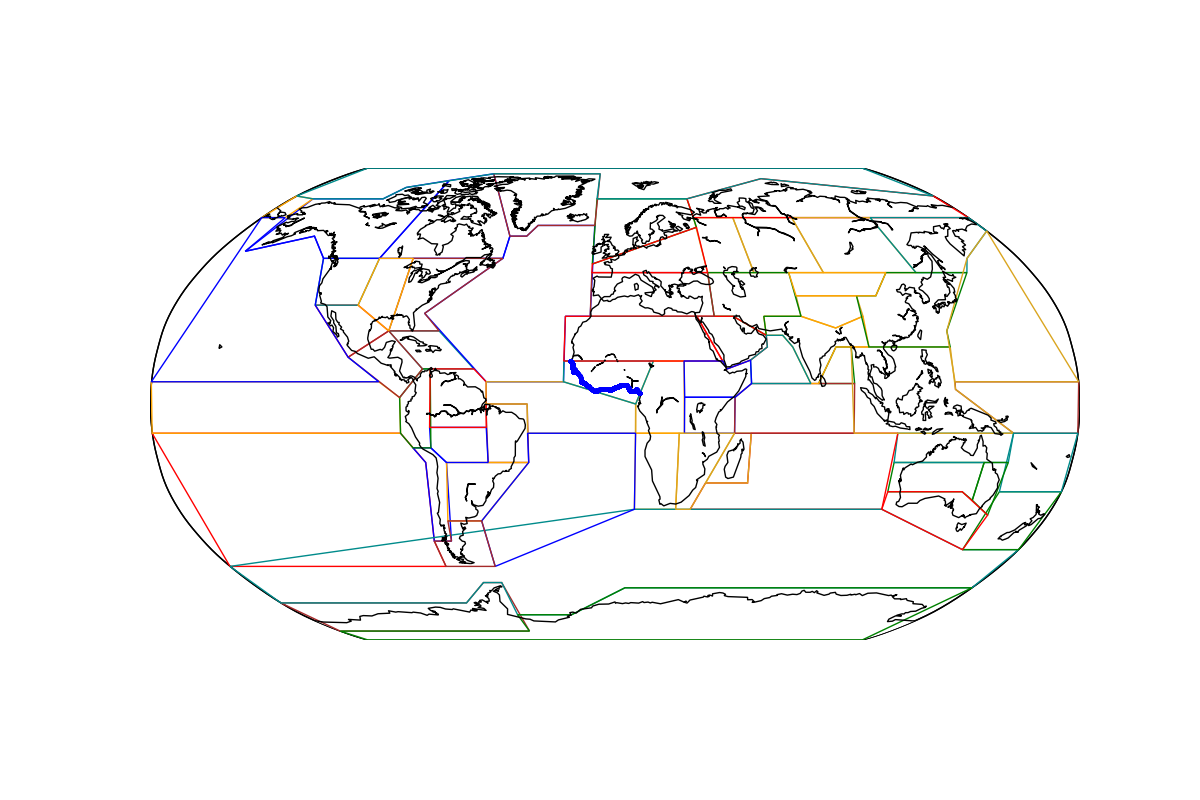

In [17]:
from IPython.display import Image
scenario = 'RCP85'
horizon = '2100'
outfilename = outdir + 'globalErosionProjections_by_AR6_region_'+scenario+'_'+horizon+'.json'
outfilename = '/home/jservon/Chapter12_IPCC/data/coastal_recession/globalErosionProjections_by_AR6_region_RCP85_2100.json'
Image(outfilename.replace('.json','.png'))

In [12]:
len(regions.keys())

62

In [14]:
subregions_names

['GIC',
 'NWN',
 'NEN',
 'WNA',
 'CNA',
 'ENA',
 'NCA',
 'SCA',
 'CAR',
 'NWS',
 'NSA',
 'NES',
 'SAM',
 'SWS',
 'SES',
 'SSA',
 'NEU',
 'WCE',
 'EEU',
 'MED',
 'SAH',
 'WAF',
 'CAF',
 'NEAF',
 'SEAF',
 'WSAF',
 'ESAF',
 'MDG',
 'RAR',
 'RAR*',
 'WSB',
 'ESB',
 'RFE',
 'WCA',
 'ECA',
 'TIB',
 'EAS',
 'ARP',
 'SAS',
 'SEA',
 'NAU',
 'CAU',
 'EAU',
 'SAU',
 'NZ',
 'EAN',
 'WAN',
 'ARO',
 'NPO',
 'NPO*',
 'EPO',
 'EPO*',
 'SPO',
 'SPO*',
 'NAO',
 'EAO',
 'SAO',
 'ARS',
 'BOB',
 'EIO',
 'SIO',
 'SOO']